{/* cspell:ignore XIXI, IZIZ, XZXZ, YZYI, ZZZI, YIYZ, ZIZZ, IXXX, XYIY, IYXY, ZYYX, YYZX, ZXYY, YXZY, quasidistillation */}

# Long-range entanglement with limited qubit connectivity
*Usage estimate: 90 minutes on IBM Sherbrooke (NOTE: This is an estimate only. Your runtime may vary.)*

In [ ]:
# This cell is hidden from users;
# it disables a linting rule that we should fix.
# ruff: noqa: E722

## Background
Long-range entanglement between distant qubits on a quantum processor can be a challenging task for devices with limited qubit connectivity. This tutorial shows three different ways that can be used to generate long-range entanglement between qubits on a line, at varying distances between each other:
- a unitary-based implementation, which uses SWAP operations to reduce the distance between distant qubits and entangle them directly,
- a measurement-based implementation with post-processing, which  discards some amount of information to generate the desired entangled state, and
- a measurement-based implementation with dynamic circuits, which uses measurement and feedforward of information during the quantum computation to entangle the qubits.
In particular, the results show the effectiveness of dynamic circuits in generating long-range entanglement between two unconnected qubits at utility scales.
The notebook uses the ideas and results from [1] by Elisa Bäumer et al.

## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime ( `pip install qiskit-ibm-runtime` ) 0.22 or later

## Setup

In [ ]:
from typing import List, Dict, Union, Optional, Callable

import random
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt


# Importing standard Qiskit libraries
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit.primitives import BitArray

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.circuit import Gate
from qiskit.circuit.library import XGate

from qiskit.providers.backend import BackendV2 as Backend
from qiskit.transpiler import CouplingMap, InstructionDurations
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_provider.transpiler.passes.scheduling import (
    DynamicCircuitInstructionDurations,
)
from qiskit_ibm_provider.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
)
from qiskit_ibm_provider.transpiler.passes.scheduling import (
    PadDynamicalDecoupling,
)
from qiskit_ibm_runtime import Batch, SamplerV2 as Sampler

from qiskit.circuit.classical import expr

from qiskit.quantum_info import Pauli, PauliList
from qiskit.result import marginal_counts

import warnings

warnings.filterwarnings("ignore")

## Step 1: Map classical inputs to a quantum problem

In this tutorial you will run a gate teleportation circuit in three different setups, where you always assume a line of n qubits (for varying n with n-2 empty ancillas in the middle and a CNOT to apply between the two ends):

- Unitary-based implementation swapping the qubits to the middle
- Measurement-based implementation with post-processing
- Measurement-based implementation with dynamic circuits

For each implementation you measure the average gate fidelity to compare among the different implementations. For details on how the average gate fidelity is calculated, see the [Appendix](#appendix-calculating-the-average-fidelity).

### Experimental setup

The experiments in this notebook use a predefined 1-D line of qubits with a coupling map that ensures that no shortcuts can be taken.

#### Define 1-D line

First, set up a line of qubits through the machine that you intend to use such that you avoid broken qubits or areas with high readout errors. To do this, examine the calibration data (which can be found online or via the command `plot_error_map(backend)`). For example, suppose that you use `ibm_sherbrooke` and that you need to avoid, for example, qubits 20 and 71 as well as qubits 56 and 73. One such qubit line would be:

![A coupling map of ibm_sherbrooke showing a subset of qubits connected by a single continuous line](/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/sherbrooke-1d-line.avif)

You describe the line as a simple list of integer indices and add that line to the `qubit_lines` dictionary.

You can visualize the coupling map and qubit indices as follows (this example is for `ibm_sherbrooke`):

In [2]:
# Current Qubit 1D lines with key the name of the machine. e.g. ibm_sherbrooke
qubit_lines = {
    "ibm_sherbrooke": [
        19,
        18,
        14,
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        17,
        30,
        29,
        28,
        27,
        26,
        25,
        24,
        34,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        55,
        68,
        69,
        70,
        74,
        89,
        88,
        87,
        86,
        85,
        84,
        83,
        82,
        80,
        79,
        78,
        77,
        76,
        75,
        90,
        94,
        95,
        96,
        97,
        98,
        99,
        100,
        101,
        102,
        103,
        104,
        105,
        106,
        107,
        108,
        112,
        126,
        125,
        124,
        123,
        122,
        121,
        120,
        119,
        118,
        117,
        116,
        115,
        114,
        113,
    ]
}

#### Set primary parameters

In this section are definitions for some common parameters that you will use later. You'll need to specify these parameters for a particular backend. In order to do so, you will need an account on [IBM Quantum&trade; Platform](https://quantum-computing.ibm.com/). More details on how to initialize your account can be found in the [documentation](https://docs.quantum.ibm.com/start/setup-channel#set-up-to-use-ibm-quantum-platform).

In [ ]:
def coupling_map_from_qubit_line(
    coupling_map: List[List[int]], qubit_line: List[List[int]]
) -> List[List[int]]:
    """
    Modify the full coupling map to force linearity in the qubit layout
    """
    new_coupling_map = []
    line_edge_list = []
    for i in range(len(qubit_line) - 1):
        line_edge_list.append([qubit_line[i], qubit_line[i + 1]])

    for edge in coupling_map:
        u, v = edge
        edge_rev = [v, u]
        if (edge in line_edge_list) or (edge_rev in line_edge_list):
            new_coupling_map.append(edge)
    return new_coupling_map


# Set up access to IBM Quantum devices
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

# Set which quantum computer to use
MACHINE_NAME = backend.name

# Set qubit line and coupling map
QUBIT_LINE = qubit_lines[MACHINE_NAME]
COUPLING_MAP_FULL = [
    list(edge)
    for edge in list(
        QiskitRuntimeService().backend(MACHINE_NAME).coupling_map
    )
]
COUPLING_MAP_1D = coupling_map_from_qubit_line(COUPLING_MAP_FULL, QUBIT_LINE)
MAX_POSSIBLE_QUBITS_BTW_CNOT = len(QUBIT_LINE) - 2

# Use this duration class to get appropriate durations for dynamic
# circuit backend scheduling
DURATIONS = DynamicCircuitInstructionDurations.from_backend(backend)

print(f"Machine is set to: {MACHINE_NAME}")
print(
    f"Maximum number of qubits between CNOT for {MACHINE_NAME} is {MAX_POSSIBLE_QUBITS_BTW_CNOT} with the given qubit line."
)

Machine is set to: ibm_sherbrooke
Maximum number of qubits between CNOT for ibm_sherbrooke is 80 with the given qubit line.


Next, set the global scope of the experiment. These variables can be used in each circuit type or can be set individually in each experiment that will override these globals.

In [4]:
# Set which Pauli's to sample (default is all 16 combinations that have a non-zero expectation)
SAMPLES = list(range(16))

# Level of optimizations the transpiler uses: There are 4 optimization levels ranging from 0 to 3,
# where higher optimization levels take more time and computational effort but may yield a more
# optimal circuit. level 0 does no explicit optimization, it will just try to make a circuit
# runnable by transforming it to match a topology and basis gate set, if necessary.
# Level 1, 2 and 3 do light, medium and heavy optimization, using a combination of passes, and by
# configuring the passes to search for better solutions.
OPTIMIZATION_LEVEL = 1

# Set to True to use dynamical decoupling
USE_DYNAMIC_DECOUPLING = True

# Default dynamic decoupling sequence if dynamic decoupling is used
DD_SEQUENCE = [XGate(), XGate()]

# Set the number of repetitions of each circuit, for sampling.
# The number of qubits between the control and target are grouped into blocks
# of length 4. The provided min and max number of qubits will be modified to
# align with these block sizes.
SHOTS = 1000

# The min number of qubits between the control and target qubits on line
MIN_NUMBER_QUBITS = 0

# The max number of qubits between the control and target qubits on line
# The max for MIN_NUMBER_QUBITS is len(QUBIT_LINE) - 2
# max_number_qubits must satisfy MAX_NUMBER_QUBITS - MIN_NUMBER_QUBITS = 3 (mod 4)
# at this point. This is just to make things easier to break jobs up. Not a real limitation.
MAX_NUMBER_QUBITS = 63
assert (
    (MAX_NUMBER_QUBITS - MIN_NUMBER_QUBITS) % 4 == 3
), "MAX_NUMBER_QUBITS must satisfy MAX_NUMBER_QUBITS - MIN_NUMBER_QUBITS = 3 (mod 4)"
assert (MAX_NUMBER_QUBITS + 2) <= len(
    QUBIT_LINE
), "MAX_NUMBER_QUBITS must satisfy MAX_NUMBER_QUBITS + 2 <= len(QUBIT_LINE)"

#### Monte Carlo state certification
Next, you utilize the methods `prep_P_ij_conj` and `meas_P_kl` to prepare the circuits for Monte Carlo state certification. The method can be used to calculate the average state fidelity of the state prepared by a circuit without having to estimate the full quantum state (for example with state tomography or similar technqiques). For more details see the [Appendix](#appendix-calculating-the-average-fidelity). Monte Carlo state certification requires us to prepare the complex conjugate of random product of eigenstates of local Pauli operators, corresponding to the Paulis $P_i^*$ and $P_j^*$ - and then to measure the the final state in different Pauli bases, corresponding to the Pauli operators $P_k$ and $P_l$. You can do this with the following two methods: the `prep_P_ij_conj` method prepares a list of circuits so that the control and target qubits are in the eigenstates of $P_i^*$ and $P_j^*$, respectively; and the `meas_P_kl` method prepares a list of circuits so that the control and target qubits are measured in the $P_k$ and $P_l$ bases, respectively.

In [5]:
def prep_P_ij_conj(
    circuits: List[QuantumCircuit], P_prep: PauliList
) -> List[QuantumCircuit]:
    """Prepare circuits with the possible complex conjugates of the eigenstates of given Pauli operators

    The first and last qubits are prepared in one of the four possible eigenstates of P_i^* and P_j^*
    respectively. The resulting collection of circuits covers all four possibilities.

    Assumes that circuits have qubits 0, ... ,n+1 where the long range NOT is between qubit 0 (control) to n+1 (target)

    Arg:
        circuits (List[QuantumCircuit]: List of 4 Quantum Circuits with at least two data qubits
        P_prep (PauliList): A pair of single qubit Paulis with the first Pauli referred to as P_i and the second as P_j

    Returns:
        List[QuantumCircuits]
    """

    pauliX = Pauli("X")
    pauliY = Pauli("Y")
    for p in range(2):
        for q in range(2):
            qc = circuits[2 * p + q]
            if p == 1:
                qc.x(0)
            if q == 1:
                qc.x(-1)
            for i in range(2):
                if P_prep[i] == pauliX:
                    qc.h(-i)
                if P_prep[i] == pauliY:
                    qc.h(-i)  # Change basis to initialise in Y^* basis
                    qc.s(-i)  # i.e. Apply SH = (HS^\dagger)^*
            circuits[2 * p + q] = qc
    return circuits


def meas_P_kl(
    circuits: List[QuantumCircuit], P_meas: PauliList
) -> List[QuantumCircuit]:
    """Prepare circuits so that the final state can be measured in different Pauli bases with a Z measurement

    The first and last qubits are the qubits that the given operator P_meas will operate

    Arg:
        circuits (List[QuantumCircuit]: List of 4 Quantum Circuits with at least two data qubits
        P_meas (PauliList): A pair of single qubit Paulis with the first Pauli referred to as P_k and the second as P_l
    """
    pauliX = Pauli("X")
    pauliY = Pauli("Y")
    for p in range(2):
        for q in range(2):
            qc = circuits[2 * p + q]
            for i in range(2):
                if P_meas[i] == pauliX:
                    qc.h(
                        -i
                    )  # Change of basis to measure X by measuring in Z basis: i.e., apply H
                if P_meas[i] == pauliY:
                    qc.sdg(
                        -i
                    )  # Change of basis to measure Y by measuring in Z basis
                    qc.h(-i)  # i.e. apply HS^dagger
            qc.measure(0, 0)
            qc.measure(-1, 1)
            circuits[2 * p + q] = qc
    return circuits

#### Unitary-based implementation swapping the qubits to the middle

First, examine the case where a long-range CNOT gate is implemented using nearest-neighbor connections and unitary gates. In the following figure, on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the right is an equivalent unitary decomposition implementable with local CNOT gates, circuit depth O(n).

![Two circuit diagrams, one showing a CNOT acting on non-neighbor qubits, and the other showing a sequence of neighbor-only CNOTs that achieve the same behaviour.](/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/swap-map-illustration.avif)

The circuit on the right can be implemented as follows:

In [6]:
def CNOT_unitary(
    qc: QuantumCircuit, control_qubit: int, target_qubit: int
) -> QuantumCircuit:
    """Generate a CNOT gate between data qubit control_qubit and data qubit target_qubit using local CNOTs

    Assumes that the long-range CNOT gate will be spanning a 1D chain of n-qubits subject to nearest-neighbor
    connections only with the chain starting at the control qubit and finishing at the target qubit.

    Assumes that control_qubit < target_qubit (as integers) and that the provided circuit qc has |0> set
    qubits control_qubit+1, ..., target_qubit-1

    Args:
        qc (QuantumCicruit) : A Quantum Circuit to add the long range localized unitary CNOT
        control_qubit (int) : The qubit used as the control.
        target_qubi (int) : The qubit targeted by the gate.

    Example:

        qc = QuantumCircuit(8,2)
        qc = CNOT_unitary(qc, 0, 7)

    Returns:
        QuantumCircuit

    """
    assert target_qubit > control_qubit
    n = target_qubit - control_qubit - 1
    k = int(n / 2)
    qc.barrier()
    for i in range(control_qubit, control_qubit + k):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)
        qc.cx(-i - 1, -i - 2)
        qc.cx(-i - 2, -i - 1)
    if n % 2 == 1:
        qc.cx(k + 2, k + 1)
        qc.cx(k + 1, k + 2)
    qc.barrier()
    qc.cx(k, k + 1)
    for i in range(control_qubit, control_qubit + k):
        qc.cx(k - i, k - 1 - i)
        qc.cx(k - 1 - i, k - i)
        qc.cx(k + i + 1, k + i + 2)
        qc.cx(k + i + 2, k + i + 1)
    if n % 2 == 1:
        qc.cx(-2, -1)
        qc.cx(-1, -2)
    qc.barrier()
    return qc

The `build_circuits_uni` method therefore builds a list of circuits to run with different Paulis $P_i, P_j, P_k$ and $P_l$ in order to estimate the state fidelity with the Monte Carlo state certification method.

In [7]:
def build_circuits_uni(n: int, samples: List[int]) -> List[QuantumCircuit]:
    """Builds the unitary circuits needed to estimate the average gate fidelity

    Args:
        samples (List[int]): Which of the 16 Paulis with non-zero expectation value to prepare and measure
        n (int): Number of qubits between the control and target of the CNOT
    """
    circuits_all = []
    # 16 Paulis with non-zero expectation value to prepare and measure
    P_lkji = PauliList(
        [
            "IIII",
            "XIXI",
            "IZIZ",
            "XZXZ",
            "YZYI",
            "ZZZI",
            "YIYZ",
            "ZIZZ",
            "XXIX",
            "IXXX",
            "XYIY",
            "IYXY",
            "ZYYX",
            "YYZX",
            "ZXYY",
            "YXZY",
        ]
    )
    for sample in samples:
        P_prep = P_lkji[sample][0:2]
        P_meas = P_lkji[sample][2:4]
        circuits = [QuantumCircuit(n + 2, 2) for i in range(4)]
        circuits = prep_P_ij_conj(
            circuits, P_prep
        )  # Prepare circuits in eigenstates P_i^* and P_j^*
        circuits = [
            CNOT_unitary(circuit, 0, n + 1) for circuit in circuits
        ]  # Add long range CNOT
        circuits = meas_P_kl(
            circuits, P_meas
        )  # Prepare circuits to measure the final state in P_k and P_l bases
        circuits_all += circuits
    return circuits_all

For example:

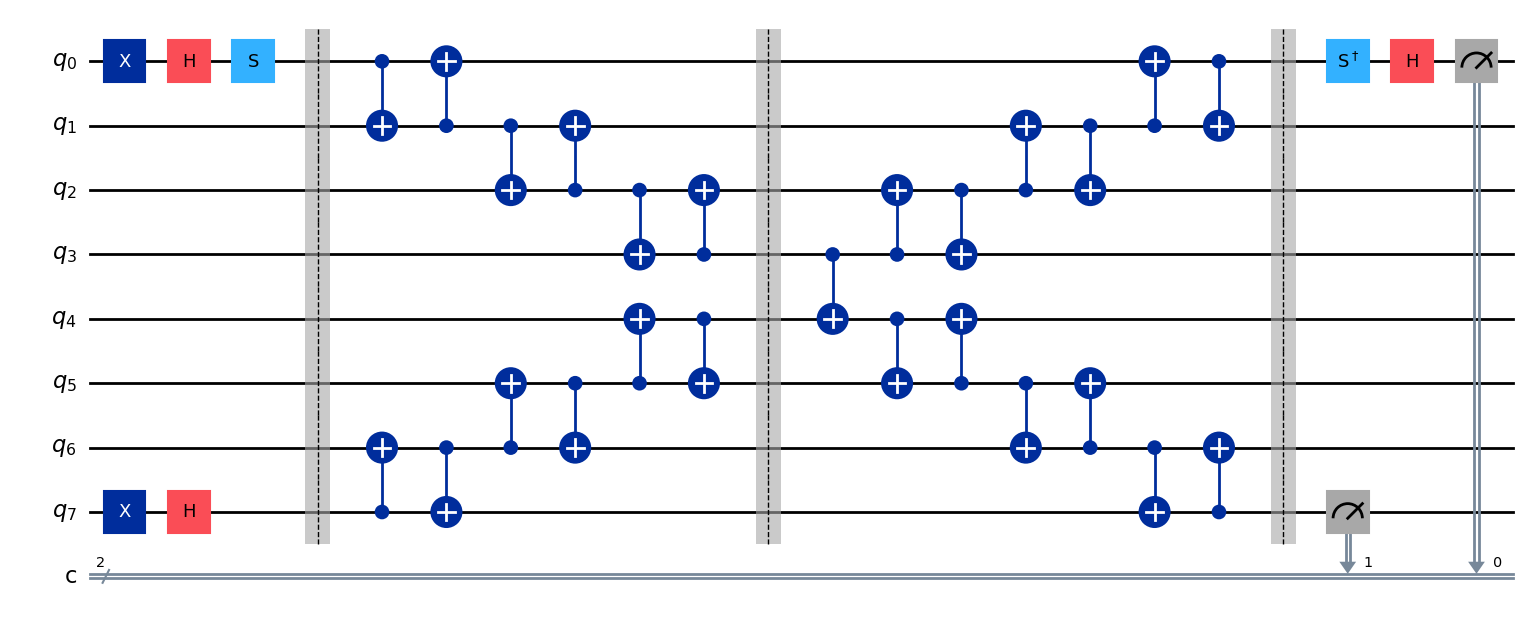

In [8]:
# Sample circuit
n = 6
sample = [11]
test_circuits = build_circuits_uni(n, sample)
test_circuits[3].draw("mpl", fold=-1)

#### Measurement-based implementation with post-processing

Next, examine the case where a long-range CNOT gate is implemented using nearest-neighbor connections of a measurement-based CNOT with post-processing. In the following figure, below on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the right is an equivalent implementable with local CNOT gates with measurements, and which requires post-processing.

![Two circuit diagrams showing a single CNOT operation before and after post processing. Both circuits are equivalent.](/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/post-processing-illustration.avif)

The circuit on the right can be implemented as follows:

In [9]:
def CNOT_postproc(
    qc: QuantumCircuit,
    control_qubit: int,
    target_qubit: int,
    c1: Optional[ClassicalRegister] = None,
    c2: Optional[ClassicalRegister] = None,
    add_barriers: Optional[bool] = True,
) -> QuantumCircuit:
    """Generate a CNOT gate between data qubit control_qubit and data qubit target_qubit using Bell Pairs.

    Post processing is used to enable the CNOT gate via the provided classical registers c1 and c2

    Assumes that the long-range CNOT gate will be spanning a 1D chain of n-qubits subject to nearest-neighbor
    connections only with the chain starting at the control qubit and finishing at the target qubit.

    Assumes that control_qubit < target_qubit (as integers) and that the provided circuit qc has |0> set
    qubits control_qubit+1, ..., target_qubit-1

    n = target_qubit - control_qubit - 1 : Number of qubits between the target and control qubits
    k = int(n/2) : Number of Bell pairs created

    Args:
        qc (QuantumCicruit) : A Quantum Circuit to add the long range localized unitary CNOT
        control_qubit (int) : The qubit used as the control.
        target_qubi (int) : The qubit targeted by the gate.

    Optional Args:
        c1 (ClassicalRegister) : Default = None. Required if n > 1. Register requires k bits
        c2 (ClassicalRegister) : Default = None. Required if n > 0. Register requires n - k bits
        add_barriers (bool) : Default = True. Include barriers before and after long range CNOT

    Returns:
        QuantumCircuit
    """
    assert target_qubit > control_qubit
    n = target_qubit - control_qubit - 1
    k = int(n / 2)

    # Determine where to start the bell pairs and
    # add an extra CNOT when n is odd
    if n % 2 == 0:
        x0 = 1
    else:
        x0 = 2
        qc.cx(0, 1)

    # Create k Bell pairs
    for i in range(k):
        qc.h(x0 + 2 * i)
        qc.cx(x0 + 2 * i, x0 + 2 * i + 1)

    # Entangle Bell pairs and data qubits and measure
    for i in range(k + 1):
        qc.cx(x0 - 1 + 2 * i, x0 + 2 * i)

    for i in range(1, k + x0):
        qc.h(2 * i + 1 - x0)
        qc.measure(2 * i + 1 - x0, c2[i - 1])

    for i in range(k):
        qc.measure(2 * i + x0, c1[i])

    if add_barriers is True:
        qc.barrier()
    return qc

Again, utilize the methods `prep_P_ij_conj` and `meas_P_kl` to prepare the circuits for Monte Carlo state certification.

In [10]:
def build_circuits_postproc(
    n: int, samples: List[int]
) -> List[QuantumCircuit]:
    """
    Args:
        n (int): Number of qubits between the control and target qubits
    """
    assert n >= 0, "Error: n needs to be a non-negative integer"
    circuits_all = []

    qr = QuantumRegister(
        n + 2, name="q"
    )  # Circuit with n qubits between control and target
    cr = ClassicalRegister(
        2, name="cr"
    )  # Classical register for measuring long range CNOT

    k = int(n / 2)  # Number of Bell States to be used
    c1 = ClassicalRegister(
        k, name="c1"
    )  # Classical register needed for post processing
    c2 = ClassicalRegister(
        n - k, name="c2"
    )  # Classical register needed for post processing

    # 16 Paulis with non-zero expectation value to prepare and measure
    P_lkji = PauliList(
        [
            "IIII",
            "XIXI",
            "IZIZ",
            "XZXZ",
            "YZYI",
            "ZZZI",
            "YIYZ",
            "ZIZZ",
            "XXIX",
            "IXXX",
            "XYIY",
            "IYXY",
            "ZYYX",
            "YYZX",
            "ZXYY",
            "YXZY",
        ]
    )

    for sample in samples:
        P_prep = P_lkji[sample][0:2]
        P_meas = P_lkji[sample][2:4]
        if n > 1:
            circuits = [
                QuantumCircuit(qr, cr, c1, c2, name="CNOT") for i in range(4)
            ]
        elif n == 1:
            circuits = [
                QuantumCircuit(qr, cr, c2, name="CNOT") for i in range(4)
            ]
        elif n == 0:
            circuits = [QuantumCircuit(qr, cr, name="CNOT") for i in range(4)]
        circuits = prep_P_ij_conj(
            circuits, P_prep
        )  # Prepare control and target qubits
        # in eigenstates of P_i^* and P_j^* respectively
        circuits = [
            CNOT_postproc(
                qc=circuit, control_qubit=0, target_qubit=n + 1, c1=c1, c2=c2
            )
            for circuit in circuits
        ]  # Add long range CNOT
        circuits = meas_P_kl(
            circuits, P_meas
        )  # Prepare circuits to measure the control and target
        # qubits in P_k and P_l bases respectively
        circuits_all += circuits
    return circuits_all

This is an example of a circuit (including the state certification step):

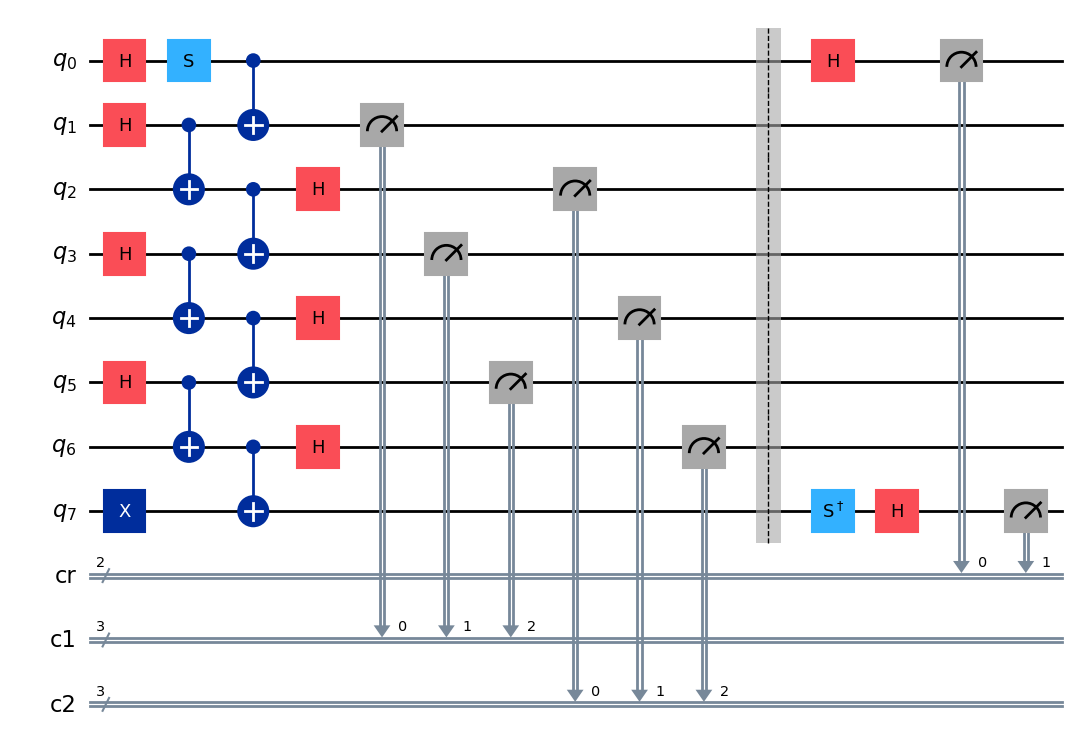

In [11]:
# Example Circuit
n = 6
sample = [15]
test_post_proc_circuits = build_circuits_postproc(n, sample)
test_post_proc_circuits[1].draw("mpl")

#### Long-range measurement-based CNOT with feedforward

Finally, examine the case where a long-range CNOT gate is implemented using measurement-based CNOT with feedforward (dynamic circuits). In the following figure, on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the right is an equivalent implementable with local CNOT gates, measurement-based CNOT with feedforward (dynamic circuits).

![Two equivalent circuits, one using feedforward](/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/feedforward-illustration.avif)

The circuit on the right can be implemented as follows:

In [12]:
def CNOT_dyn(
    qc: QuantumCircuit,
    control_qubit: int,
    target_qubit: int,
    c1: Optional[ClassicalRegister] = None,
    c2: Optional[ClassicalRegister] = None,
    add_barriers: Optional[bool] = True,
) -> QuantumCircuit:
    """Generate a CNOT gate between data qubit control_qubit and data qubit target_qubit using Bell Pairs.

    Post processing is used to enable the CNOT gate via the provided classical registers c1 and c2

    Assumes that the long-range CNOT gate will be spanning a 1D chain of n-qubits subject to nearest-neighbor
    connections only with the chain starting at the control qubit and finishing at the target qubit.

    Assumes that control_qubit < target_qubit (as integers) and that the provided circuit qc has |0> set
    qubits control_qubit+1, ..., target_qubit-1

    n = target_qubit - control_qubit - 1 : Number of qubits between the target and control qubits
    k = int(n/2) : Number of Bell pairs created

    Args:
        qc (QuantumCicruit) : A Quantum Circuit to add the long range localized unitary CNOT
        control_qubit (int) : The qubit used as the control.
        target_qubi (int) : The qubit targeted by the gate.

    Optional Args:
        c1 (ClassicalRegister) : Default = None. Required if n > 1. Register requires k bits
        c2 (ClassicalRegister) : Default = None. Required if n > 0. Register requires n - k bits
        add_barriers (bool) : Default = True. Include barriers before and after long range CNOT

    Note: This approached uses two if_test statements. A better (more performant) approach is
    to have the parity values combined into a single classical register and then use a switch
    statement. This was done in the associated paper my modifying the qasm file directly. The ability
    to use a switch statement via Qiskit in this way is a future release capability.

    Returns:
        QuantumCircuit
    """
    assert target_qubit > control_qubit
    n = target_qubit - control_qubit - 1
    t = int(n / 2)

    if add_barriers is True:
        qc.barrier()

    # Determine where to start the bell pairs and
    # add an extra CNOT when n is odd
    if n % 2 == 0:
        x0 = 1
    else:
        x0 = 2
        qc.cx(0, 1)

    # Create t Bell pairs
    for i in range(t):
        qc.h(x0 + 2 * i)
        qc.cx(x0 + 2 * i, x0 + 2 * i + 1)

    # Entangle Bell pairs and data qubits and measure
    for i in range(t + 1):
        qc.cx(x0 - 1 + 2 * i, x0 + 2 * i)

    for i in range(1, t + x0):
        if i == 1:
            qc.h(2 * i + 1 - x0)
            qc.measure(2 * i + 1 - x0, c2[i - 1])
            parity_control = expr.lift(c2[i - 1])
        else:
            qc.h(2 * i + 1 - x0)
            qc.measure(2 * i + 1 - x0, c2[i - 1])
            parity_control = expr.bit_xor(c2[i - 1], parity_control)

    for i in range(t):
        if i == 0:
            qc.measure(2 * i + x0, c1[i])
            parity_target = expr.lift(c1[i])
        else:
            qc.measure(2 * i + x0, c1[i])
            parity_target = expr.bit_xor(c1[i], parity_target)

    if n > 0:
        with qc.if_test(parity_control):
            qc.z(0)

    if n > 1:
        with qc.if_test(parity_target):
            qc.x(-1)

    if add_barriers is True:
        qc.barrier()
    return qc

Put it together with the Monte Carlo state certification methods `prep_P_ij_conj` and `meas_P_kl`:

In [13]:
def build_circuits_dyn(n: int, samples: List[int]) -> List[QuantumCircuit]:
    """ """
    assert n >= 0, "Error: n needs to be a non-negative integer"
    circuits_all = []

    qr = QuantumRegister(
        n + 2, name="q"
    )  # Circuit with n qubits between control and target
    cr = ClassicalRegister(
        2, name="cr"
    )  # Classical register for measuring long range CNOT

    k = int(n / 2)  # Number of Bell States to be used
    c1 = ClassicalRegister(
        k, name="c1"
    )  # Classical register needed for post processing
    c2 = ClassicalRegister(
        n - k, name="c2"
    )  # Classical register needed for post processing

    # 16 Paulis with non-zero expectation value to prepare and measure
    P_lkji = PauliList(
        [
            "IIII",
            "XIXI",
            "IZIZ",
            "XZXZ",
            "YZYI",
            "ZZZI",
            "YIYZ",
            "ZIZZ",
            "XXIX",
            "IXXX",
            "XYIY",
            "IYXY",
            "ZYYX",
            "YYZX",
            "ZXYY",
            "YXZY",
        ]
    )

    for sample in samples:
        P_prep = P_lkji[sample][0:2]
        P_meas = P_lkji[sample][2:4]
        if n > 1:
            circuits = [
                QuantumCircuit(qr, cr, c1, c2, name="CNOT") for i in range(4)
            ]
        elif n == 1:
            circuits = [
                QuantumCircuit(qr, cr, c2, name="CNOT") for i in range(4)
            ]
        elif n == 0:
            circuits = [QuantumCircuit(qr, cr, name="CNOT") for i in range(4)]
        circuits = prep_P_ij_conj(
            circuits, P_prep
        )  # Prepare control and target qubits
        # in eigenstates of P_i^* and P_j^* respectively
        circuits = [
            CNOT_dyn(
                qc=circuit, control_qubit=0, target_qubit=n + 1, c1=c1, c2=c2
            )
            for circuit in circuits
        ]  # Add long range CNOT
        circuits = meas_P_kl(
            circuits, P_meas
        )  # Prepare circuits to measure the control and target
        # qubits in P_k and P_l bases respectively
        circuits_all += circuits
    return circuits_all

This results in the following example:

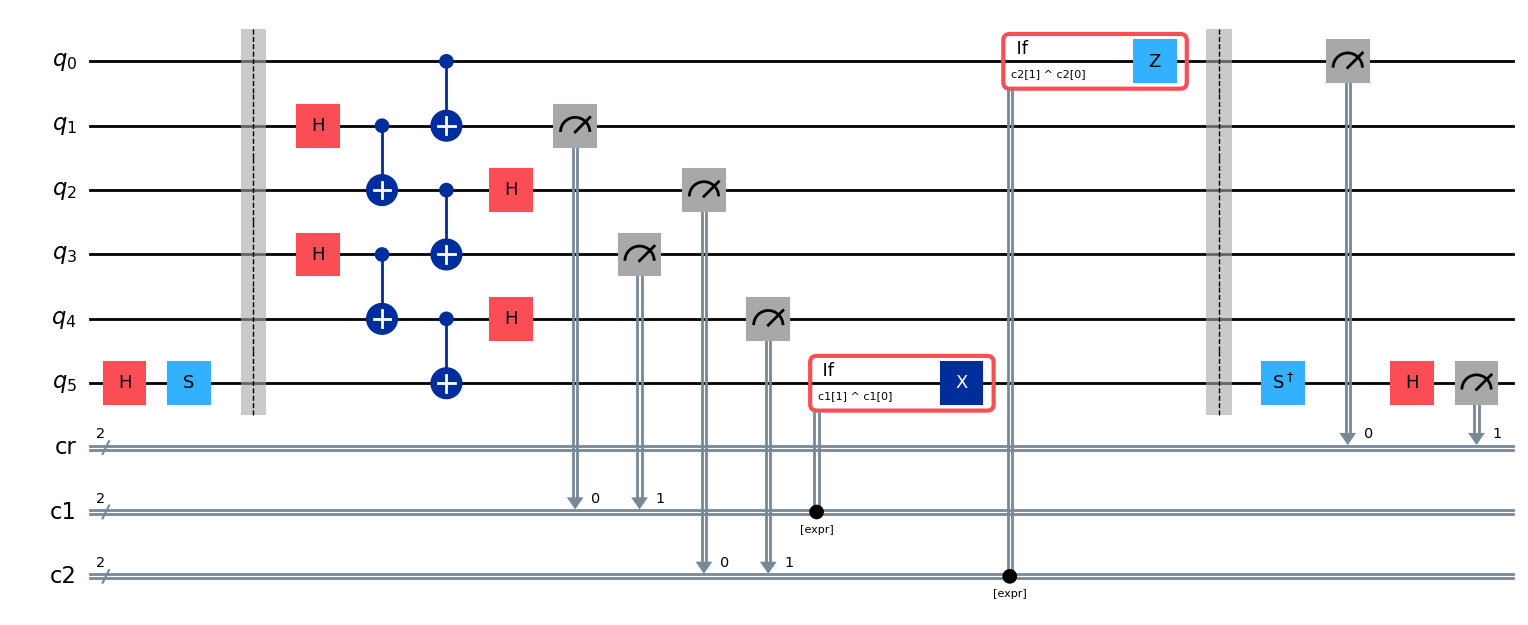

In [14]:
# View an example circuit with Monte Carlo Prep

n_qubits = 4
sample = range(16)
example_post_proc_circuits = build_circuits_dyn(n_qubits, sample)
example_post_proc_circuits[16].draw("mpl")

## Step 2: Optimize problem for quantum hardware execution

Because you have already specified the physical qubit layout and built the circuits with a line topology in mind, there is no need to further optimize the circuits.

## Step 3: Execute using Qiskit primitives
In this step you execute the experiment on the specified backend. A lightweight transpilation is done before submission to ensure that the circuits have all the physical parameters needed for execution on the device. This is done in the `submit_circuits` function, which also splits the circuits into smaller batches to be submitted to the device.

In [15]:
def submit_circuits(
    min_qubits: int,
    max_qubits: int,
    num_circuits_per_job: int,
    qubit_line: List[int],
    coupling_map: Union[CouplingMap, List],
    samples: List[int],
    optimization_level: int,
    backend: Backend,
    shots: int,
    build_circuits: Callable,
    transpile_dynamic: Optional[bool] = True,
    use_dynamic_decoupling: Optional[bool] = True,
    dd_sequence: Optional[List[Gate]] = [XGate(), XGate()],
    durations: Optional[InstructionDurations] = None,
) -> List[str]:
    """
    Submit circuits in appropriate batches
    """

    # Calculated constants and storage variables
    line_length = len(qubit_line)
    num_samples = len(samples)
    num_circuits = (max_qubits - min_qubits + 1) * 4 * num_samples
    nr_jobs = int(num_circuits / num_circuits_per_job)

    # Run some parameter checks
    # Min number of qubits between control and target must be a non-negative integer
    assert min_qubits >= 0, "Error: min_qubits must be >= 0"

    # Max number of qubits between control and target musts be <= line_length - 2
    assert (
        max_qubits + 2
    ) <= line_length, "Error: max_qubits must be <= len(qubit_line) - 2"

    # (max_qubits - min_qubits) must equal to 3(mod 4)
    rem = (max_qubits - min_qubits) % 4
    assert rem == 3, "Fail: (max_qubits - min_qubits) must equal to 3(mod 4)"

    # First transpile all the circuits
    print("Transpiling circuits...")

    all_transpiled_circs = []

    for n in range(min_qubits, max_qubits + 1):
        layout = qubit_line[: n + 2]
        circuits = build_circuits(n, samples)

        clear_output(wait=True)
        percentage_completed = (n - min_qubits + 1) / (
            max_qubits - min_qubits + 1
        )

        print(
            f"[{percentage_completed:.0%} completed] Transpiling circuits "
            + f"with {n} qubits between CNOT"
        )

        # Generate the main Qiskit transpile passes.
        pm = generate_preset_pass_manager(
            coupling_map=coupling_map,
            initial_layout=layout,
            optimization_level=optimization_level,
            backend=backend,
        )

        if use_dynamic_decoupling is True:
            # Configure the as-late-as-possible scheduling pass and DD insertion pass
            pm.scheduling = PassManager(
                [
                    ALAPScheduleAnalysis(durations),
                    PadDynamicalDecoupling(durations, dd_sequence),
                ]
            )

        transpiled_circuits = pm.run(circuits)
        all_transpiled_circs.extend(transpiled_circuits)

    clear_output(wait=True)
    print("Sumbitting jobs ...")

    job_ids = []

    with Batch(backend=backend) as batch:
        sampler = Sampler(session=batch)
        for job_num in range(nr_jobs):
            transpiled_circs = all_transpiled_circs[
                num_circuits_per_job * job_num : num_circuits_per_job
                * (job_num + 1)
            ]

            # Submit circuits
            print("Submitting circuits:")

            percentage_completed = job_num / nr_jobs
            print(f"[{percentage_completed:.0%} completed]")

            job = sampler.run(transpiled_circs, shots=shots)
            job_ids.append(job.job_id())
            print(
                "Job id for circuits "
                + f"[{num_circuits_per_job*nr_jobs}, {num_circuits_per_job*(nr_jobs + 1) -1 }] : {job.job_id()}"
            )

            clear_output(wait=True)

        clear_output(wait=True)
    print("All jobs submitted.\n")

    # Display qubit ranges and job ids
    for job_num in range(nr_jobs):
        print(
            f"[{num_circuits_per_job*job_num}, {num_circuits_per_job*(job_num + 1)}]: "
            f"Id = {job_ids[job_num]}"
        )

    return job_ids

First, set the parameters for the unitary approach and submit circuits.

In [16]:
# Set local parameters
SAMPLES_UNI = SAMPLES
OPTIMIZATION_LEVEL_UNI = OPTIMIZATION_LEVEL
SHOTS_UNI = SHOTS
MIN_NUMBER_QUBITS_UNI = MIN_NUMBER_QUBITS
MAX_NUMBER_QUBITS_UNI = MAX_NUMBER_QUBITS
NUM_CIRCUITS_PER_JOB_UNI = 256
USE_DYNAMIC_DECOUPLING_UNI = False

# Submit jobs for using unitary circuit approach
job_ids_uni = submit_circuits(
    MIN_NUMBER_QUBITS_UNI,
    MAX_NUMBER_QUBITS_UNI,
    NUM_CIRCUITS_PER_JOB_UNI,
    QUBIT_LINE,
    COUPLING_MAP_1D,
    SAMPLES_UNI,
    OPTIMIZATION_LEVEL_UNI,
    backend,
    SHOTS_UNI,
    build_circuits_uni,
    use_dynamic_decoupling=USE_DYNAMIC_DECOUPLING_UNI,
)

All jobs submitted.

[0, 256]: Id = cskwzwfvnxy0008d6m8g
[256, 512]: Id = cskwzx73fxq0008c9t60
[512, 768]: Id = cskwzxzvnxy0008d6m9g
[768, 1024]: Id = cskwzyzvnxy0008d6mb0
[1024, 1280]: Id = cskwzzqvnxy0008d6mbg
[1280, 1536]: Id = cskx00rp1vzg008a4neg
[1536, 1792]: Id = cskx0203fxq0008c9t8g
[1792, 2048]: Id = cskx038p1vzg008a4ng0
[2048, 2304]: Id = cskx04gvwqp0008avw10
[2304, 2560]: Id = cskx060vwqp0008avw20
[2560, 2816]: Id = cskx07g1k2e0008nz7pg
[2816, 3072]: Id = cskx091p1vzg008a4nh0
[3072, 3328]: Id = cskx0b11k2e0008nz7q0
[3328, 3584]: Id = cskx0csvwqp0008avw4g
[3584, 3840]: Id = cskx0esvwqp0008avw50
[3840, 4096]: Id = cskx0gtvnxy0008d6mf0


Then, do the same for the measurement-based post-selection approach.

In [17]:
# Set local parameters
SAMPLES_POSTPROC = SAMPLES
OPTIMIZATION_LEVEL_POSTPROC = OPTIMIZATION_LEVEL
SHOTS_POSTPROC = SHOTS
MIN_NUMBER_QUBITS_POSTPROC = MIN_NUMBER_QUBITS
MAX_NUMBER_QUBITS_POSTPROC = MAX_NUMBER_QUBITS
NUM_CIRCUITS_PER_JOB_POSTPROC = 128
USE_DYNAMIC_DECOUPLING_POSTPROC = USE_DYNAMIC_DECOUPLING
DURATIONS_POSTPROC = DURATIONS

# Submit jobs for the measurement based post selection approach
job_ids_postproc = submit_circuits(
    MIN_NUMBER_QUBITS_POSTPROC,
    MAX_NUMBER_QUBITS_POSTPROC,
    NUM_CIRCUITS_PER_JOB_POSTPROC,
    QUBIT_LINE,
    COUPLING_MAP_1D,
    SAMPLES_POSTPROC,
    OPTIMIZATION_LEVEL_POSTPROC,
    backend,
    SHOTS_POSTPROC,
    build_circuits_postproc,
    use_dynamic_decoupling=USE_DYNAMIC_DECOUPLING_POSTPROC,
    durations=DURATIONS_POSTPROC,
)

All jobs submitted.

[0, 128]: Id = cskxtx3p1vzg008a4qx0
[128, 256]: Id = cskxtxkvwqp0008aw0b0
[256, 384]: Id = cskxtybea560008f8sj0
[384, 512]: Id = cskxtykea560008f8sk0
[512, 640]: Id = cskxtzb1k2e0008nzbh0
[640, 768]: Id = cskxtzv3fxq0008c9xdg
[768, 896]: Id = cskxv0c1k2e0008nzbhg
[896, 1024]: Id = cskxv0w3fxq0008c9xe0
[1024, 1152]: Id = cskxv1cea560008f8skg
[1152, 1280]: Id = cskxv1w3fxq0008c9xf0
[1280, 1408]: Id = cskxv2c1k2e0008nzbjg
[1408, 1536]: Id = cskxv34vnxy0008d6r7g
[1536, 1664]: Id = cskxv3mea560008f8sm0
[1664, 1792]: Id = cskxv4c1k2e0008nzbkg
[1792, 1920]: Id = cskxv543fxq0008c9xg0
[1920, 2048]: Id = cskxv5m1k2e0008nzbm0
[2048, 2176]: Id = cskxv6c1k2e0008nzbn0
[2176, 2304]: Id = cskxv6w1k2e0008nzbng
[2304, 2432]: Id = cskxv7mvnxy0008d6r9g
[2432, 2560]: Id = cskxv8d3fxq0008c9xgg
[2560, 2688]: Id = cskxv95p1vzg008a4qz0
[2688, 2816]: Id = cskxv9x3fxq0008c9xhg
[2816, 2944]: Id = cskxvanvwqp0008aw0e0
[2944, 3072]: Id = cskxvbdea560008f8sp0
[3072, 3200]: Id = cskxvc51k2e0008nz

Finally, for the measurement-based dynamic circuit approach:

In [18]:
# Set local parameters
SAMPLES_DYN = SAMPLES
OPTIMIZATION_LEVEL_DYN = OPTIMIZATION_LEVEL
SHOTS_DYN = SHOTS
MIN_NUMBER_QUBITS_DYN = MIN_NUMBER_QUBITS
MAX_NUMBER_QUBITS_DYN = MAX_NUMBER_QUBITS
DURATIONS_DYN = DURATIONS
DD_SEQUENCE_DYN = DD_SEQUENCE
NUM_CIRCUITS_PER_JOB_DYN = 16
USE_DYNAMIC_DECOUPLING_DYN = USE_DYNAMIC_DECOUPLING

# Submit jobs for the measurement based dynamic circuit approach
job_ids_dyn = submit_circuits(
    MIN_NUMBER_QUBITS_DYN,
    MAX_NUMBER_QUBITS_DYN,
    NUM_CIRCUITS_PER_JOB_DYN,
    QUBIT_LINE,
    COUPLING_MAP_1D,
    SAMPLES_DYN,
    OPTIMIZATION_LEVEL_DYN,
    backend,
    SHOTS_DYN,
    build_circuits_dyn,
    durations=DURATIONS_DYN,
)

All jobs submitted.

[0, 16]: Id = cskyn0cvwqp0008aw420
[16, 32]: Id = cskyn0m3fxq0008ca280
[32, 48]: Id = cskyn0wea560008f8y90
[48, 64]: Id = cskyn14vnxy0008d6vqg
[64, 80]: Id = cskyn1cea560008f8y9g
[80, 96]: Id = cskyn1wea560008f8ya0
[96, 112]: Id = cskyn241k2e0008nzg40
[112, 128]: Id = cskyn2c3fxq0008ca290
[128, 144]: Id = cskyn2mvnxy0008d6vr0
[144, 160]: Id = cskyn34ea560008f8yag
[160, 176]: Id = cskyn3mp1vzg008a4v8g
[176, 192]: Id = cskyn3wp1vzg008a4v90
[192, 208]: Id = cskyn441k2e0008nzg4g
[208, 224]: Id = cskyn4cvnxy0008d6vrg
[224, 240]: Id = cskyn4m3fxq0008ca2b0
[240, 256]: Id = cskyn4w3fxq0008ca2bg
[256, 272]: Id = cskyn54vwqp0008aw440
[272, 288]: Id = cskyn5mea560008f8ybg
[288, 304]: Id = cskyn5wvwqp0008aw44g
[304, 320]: Id = cskyn64ea560008f8ycg
[320, 336]: Id = cskyn6c3fxq0008ca2c0
[336, 352]: Id = cskyn6mp1vzg008a4v9g
[352, 368]: Id = cskyn74ea560008f8yd0
[368, 384]: Id = cskyn7cea560008f8ydg
[384, 400]: Id = cskyn7mea560008f8ye0
[400, 416]: Id = cskyn7w1k2e0008nzg60
[416,

## Step 4: Post-process and return result in desired classical format

After the experiments have successfully executed, proceed to post-process the resulting counts to gain insight on the final results. You can take advantage of resampling techniques (also known as [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))) to calculate average fidelities and deviations from the experimental counts.

In [19]:
def resample_single_dictionary(d):
    """Resample a single dictionary based on its weights."""
    keys = list(d.keys())
    weights = list(d.values())
    total = sum(weights)

    resampled_keys = random.choices(keys, weights=weights, k=total)

    # Count the occurrences of each key in the resampled keys
    resampled_counts = {}
    for key in resampled_keys:
        resampled_counts[key] = resampled_counts.get(key, 0) + 1

    return resampled_counts


def resample_dict_list(dict_list, n_samples):
    """Resample the entire list of dictionaries n_samples times."""
    resampled_lists = []

    for _ in range(n_samples):
        new_version = [resample_single_dictionary(d) for d in dict_list]
        resampled_lists.append(new_version)

    return resampled_lists

In addition, to post-process the results, you need to extract the information from the Monte Carlo state certification protocol - thus, depending on the preparation/measurement basis, you will group the results differently. The utility functions below are meant to carry out this procedure:

In [20]:
def parity(string: str) -> int:
    return string.count("1") % 2


def parities(string: str) -> str:
    strings = string.split()
    parities = [parity(val) for val in strings]
    return parities


def postproc_counts(counts, i, samples):
    P_lkji = PauliList(
        [
            "IIII",
            "XIXI",
            "IZIZ",
            "XZXZ",
            "YZYI",
            "ZZZI",
            "YIYZ",
            "ZIZZ",
            "XXIX",
            "IXXX",
            "XYIY",
            "IYXY",
            "ZYYX",
            "YYZX",
            "ZXYY",
            "YXZY",
        ]
    )

    PauliI = Pauli("I")
    PauliX = Pauli("X")
    PauliZ = Pauli("Z")

    P_k = P_lkji[samples[i]][2]
    P_l = P_lkji[samples[i]][3]

    # determine parities
    counts_post = {"00": 0, "01": 0, "10": 0, "11": 0}

    for key in counts:
        parities_list = parities(key)
        w = len(parities_list)
        if w == 3:
            parity_of_c2, parity_of_c1, _ = parities_list
        elif w == 2:
            parity_of_c1 = 0
            parity_of_c2, _ = parities_list
        else:
            parity_of_c1 = 0
            parity_of_c2 = 0

        # add parity_of_c2 to q0 (key[-1]) only if P_k is 'X' or 'Y'
        if P_k == PauliI or P_k == PauliZ:
            parity_of_c2 = 0

        # add parity_c1 to q1 (key[-2]) only if P_l is 'I' or 'Z' or 'Y'
        if P_l == PauliX:
            parity_of_c1 = 0

        control_qubit_value = int(key[-1])  # Control qubit q0
        target_qubit_value = int(key[-2])  # Target qubit q1

        new_control_qubit_value = (control_qubit_value + parity_of_c2) % 2
        new_target_qubit_value = (target_qubit_value + parity_of_c1) % 2

        new_key = str(new_target_qubit_value) + str(new_control_qubit_value)

        counts_post[new_key] += counts[key]

    return counts_post


def post_process_postproc(count, i, p, q, samples):
    return postproc_counts(count, i, samples)


def post_process_dyn(count, i, p, q, samples):
    return marginal_counts(count, indices=range(2))


def process_fidelities(
    counts: Union[dict[str, int], List[dict[str, int]]],
    samples: List[int],
    shots: int,
    post_process: Optional[Callable] = None,
) -> List[float]:
    """Calculate the estimated process fidelities from experiment counts data

    Args:
        counts (dict[str:int] or List[dict[str:int]]): counts data from an experiment
        samples (List[int]): which of the 16 Paulis with non-zero expectation value to prepare and measure
        shots (int): Number of shots used in experiment
        post_process (Callable): Post process the counts with post_proc if given. Default = None
    """
    exp_all = []
    # 16 Paulis with non-zero expectation value to prepare and measure
    P_lkji = PauliList(
        [
            "IIII",
            "XIXI",
            "IZIZ",
            "XZXZ",
            "YZYI",
            "ZZZI",
            "YIYZ",
            "ZIZZ",
            "XXIX",
            "IXXX",
            "XYIY",
            "IYXY",
            "ZYYX",
            "YYZX",
            "ZXYY",
            "YXZY",
        ]
    )
    sign_rho_lkji = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1]

    PauliI = Pauli("I")

    for i in range(len(samples)):
        P_i = P_lkji[samples[i]][0]
        P_j = P_lkji[samples[i]][1]
        P_k = P_lkji[samples[i]][2]
        P_l = P_lkji[samples[i]][3]

        exp = 0
        # initial state p with eig value p_eig prepared
        for p in range(2):
            if P_i == PauliI:
                p_eig = 1
            else:
                p_eig = (-1) ** p

            # initial state q with eig value q_eig prepared
            for q in range(2):
                if P_j == PauliI:
                    q_eig = 1
                else:
                    q_eig = (-1) ** q

                # post process count if provided
                if post_process is not None:
                    if len(counts) > 0:
                        counts_post = post_process(
                            counts[i * 4 + 2 * p + q], i, p, q, samples
                        )
                else:
                    if len(counts) > 0:
                        counts_post = counts[i * 4 + 2 * p + q]

                # measurement projecting to states r with eig value r_eig
                for r in range(2):
                    if P_k == PauliI:
                        r_eig = 1
                    else:
                        r_eig = (-1) ** r
                    for s in range(2):
                        if P_l == PauliI:
                            s_eig = 1
                        else:
                            s_eig = (-1) ** s

                        str_r = str(r)
                        str_s = str(s)
                        try:
                            exp += (
                                p_eig
                                * q_eig
                                * s_eig
                                * r_eig
                                * counts_post[str_s + str_r]
                                / shots
                                / 4
                                / sign_rho_lkji[samples[i]]
                            )
                        except:
                            pass

        exp_all.append(exp)
    return exp_all


def get_counts_from_bitarray(instance):
    """
    Extract counts from result data
    """
    for field, value in instance.__dict__.items():
        if isinstance(value, BitArray):
            return value.get_counts()
    return None


def cal_average_fidelities(
    job_ids: List[str],
    min_qubits: int,
    max_qubits: int,
    samples: List[int],
    shots: int,
    num_circuits_per_job: int,
    post_process: Optional[Callable] = None,
    all_counts: Optional[List[Dict]] = None,
    display: Optional[bool] = True,
    debug: Optional[bool] = False,
    n_bootstrap_sample: Optional[int] = 4,
) -> (List[float], List[float]):
    """
    Calculate the average gate fidelities
    """

    proc_fidelities = []
    proc_std = []
    nr_jobs = len(job_ids)
    num_samples = len(samples)
    empty_counts = {"00": 0, "01": 0, "10": 0, "11": 0}
    if all_counts is None:
        counts_flag = False
        all_counts = []
    else:
        counts_flag = True

    if debug is True:
        print(f"{nr_jobs} to process")
    if len(all_counts) == 0:
        for j in range(nr_jobs):
            job = service.job(job_ids[j])

            if str(job.status()) == "JobStatus.DONE":
                if display is True:
                    print(
                        f"Retrieving job data: {job_ids[j]}: {j} of {nr_jobs-1}"
                    )
                result = job.result()
                for i in range(len(result)):
                    counts = get_counts_from_bitarray(result[i].data)
                    # if post_process=='post_process_postproc' or post_process == 'post_process_dyn':
                    #     counts = result[i].data.cr.get_counts()
                    # else:
                    #     counts = result[i].data.cr.get_counts()
                    all_counts.append(counts)

            else:
                print(
                    f"Warning: Job id : {job_ids[j]} returned status of {job.status()} : Adding empty dictionaries"
                )
                all_counts += [empty_counts] * num_circuits_per_job
            if debug is False:
                clear_output(wait=True)
    else:
        print("Using provided all_counts data instead of loading from server")
        print(all_counts)

    for n in range(min_qubits, max_qubits + 1):
        if display is True:
            print(
                f"Resampling counts for n = {n}: {max_qubits + 1 - n} remaining"
            )
        counts = all_counts[
            (n - min_qubits) * 4 * num_samples : (n - min_qubits + 1)
            * 4
            * num_samples
        ]
        proc_fid_temp = []

        for _ in range(n_bootstrap_sample):
            resample_counts = resample_dict_list(counts, 1)[0]
            sample_fidelities = process_fidelities(
                resample_counts, samples, shots, post_process
            )
            proc_fid_temp.append(np.mean(sample_fidelities))

        mean, std = (
            np.mean(np.array(proc_fid_temp)),
            np.std(np.array(proc_fid_temp)),
        )
        proc_fidelities.append(mean)
        proc_std.append(std)
        if debug is False:
            clear_output(wait=True)

    if display is True:
        print("Process fidelities:")
        print(["{0:0.3f}".format(i) for i in proc_fidelities])
        print("Process fidelities std:")
        print(["{0:0.3f}".format(i) for i in proc_std])

    # Calculate average gate fidelity from the process fidelity

    avg_gate_fidelities = []

    for i in range(len(proc_fidelities)):
        # Use result of Horodecki et al. to calculate the average gate fidelity
        avg_gate_fidelity = (proc_fidelities[i] * 4 + 1) / 5
        avg_gate_fidelities.append(avg_gate_fidelity)

    if display is True:
        print("Average Gate Fidelites")
        print(["{0:0.3f}".format(i) for i in avg_gate_fidelities])

    # Calculate average gate fidelity std from the process fidelity std

    avg_gate_stds = []

    for i in range(len(proc_std)):
        # We scale the std as in the average gate fidelity
        avg_gate_std = (proc_std[i] * 4) / 5
        avg_gate_stds.append(avg_gate_std)

    if display is True:
        print("Average Gate Std")
        print(["{0:0.3f}".format(i) for i in avg_gate_stds])

    if counts_flag is True:
        return (avg_gate_fidelities, avg_gate_stds, all_counts)
    else:
        return (avg_gate_fidelities, avg_gate_stds)

In [22]:
# No post processing of the counts is required in the Unitary circuits. The average gate fidelities can now be calculated:
avg_gate_fidelities_uni, avg_gate_stds_uni = cal_average_fidelities(
    job_ids_uni,
    MIN_NUMBER_QUBITS_UNI,
    MAX_NUMBER_QUBITS_UNI,
    SAMPLES_UNI,
    SHOTS_UNI,
    NUM_CIRCUITS_PER_JOB_UNI,
)


avg_gate_fidelities_postproc, avg_gate_stds_postproc = cal_average_fidelities(
    job_ids_postproc,
    MIN_NUMBER_QUBITS_POSTPROC,
    MAX_NUMBER_QUBITS_POSTPROC,
    SAMPLES_POSTPROC,
    SHOTS_POSTPROC,
    NUM_CIRCUITS_PER_JOB_POSTPROC,
    post_process=post_process_postproc,
)


avg_gate_fidelities_dyn, avg_gate_stds_dyn = cal_average_fidelities(
    job_ids_dyn,
    MIN_NUMBER_QUBITS_DYN,
    MAX_NUMBER_QUBITS_DYN,
    SAMPLES_DYN,
    SHOTS_DYN,
    NUM_CIRCUITS_PER_JOB_DYN,
    post_process=post_process_dyn,
)

Process fidelities:
['0.873', '0.516', '0.372', '0.413', '0.431', '0.487', '0.332', '0.448', '0.341', '0.157', '0.300', '0.336', '0.296', '0.335', '0.269', '0.256', '0.252', '0.273', '0.189', '0.284', '0.229', '0.273', '0.236', '0.144', '0.214', '0.257', '0.199', '0.266', '0.215', '0.257', '0.211', '0.235', '0.202', '0.215', '0.234', '0.235', '0.198', '0.169', '0.182', '0.208', '0.202', '0.210', '0.177', '0.191', '0.129', '0.135', '0.193', '0.207', '0.196', '0.175', '0.194', '0.201', '0.177', '0.195', '0.166', '0.160', '0.156', '0.150', '0.156', '0.184', '0.191', '0.178', '0.174', '0.131']
Process fidelities std:
['0.002', '0.002', '0.001', '0.004', '0.004', '0.004', '0.005', '0.003', '0.004', '0.002', '0.005', '0.005', '0.004', '0.003', '0.003', '0.004', '0.005', '0.001', '0.003', '0.004', '0.005', '0.003', '0.003', '0.001', '0.003', '0.002', '0.002', '0.004', '0.004', '0.003', '0.002', '0.003', '0.000', '0.003', '0.003', '0.001', '0.001', '0.003', '0.005', '0.003', '0.003', '0.002', 

### Plot the results
To appreciate the results visually, the cell below plots the estimated gate fidelities measured at varying distance between entangled qubits for the three different methods. In general, the fidelity will decrease with increasing distance. The results show that although the unitary method (using SWAPs to implement a long-range entangling interaction) performs better at short distances, there is a cross-over to a regime where dynamic circuits become a better option. This is true for both the measurement-and-feedforward technique as well as the post-processing one.

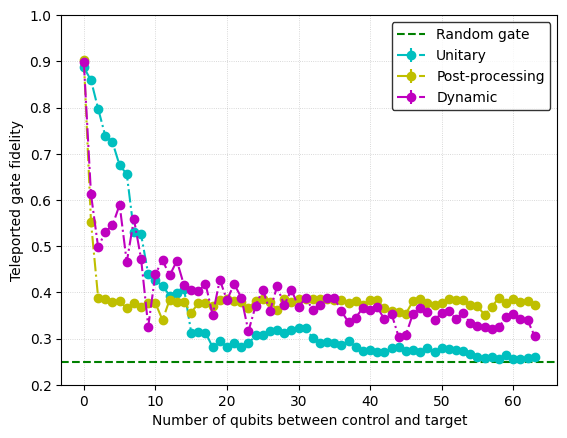

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(
    range(MIN_NUMBER_QUBITS_UNI, MAX_NUMBER_QUBITS_UNI + 1),
    avg_gate_fidelities_uni,
    avg_gate_stds_uni,
    fmt="o-.",
    color="c",
    label="Unitary",
)
ax.errorbar(
    range(MIN_NUMBER_QUBITS_UNI, MAX_NUMBER_QUBITS_UNI + 1),
    avg_gate_fidelities_postproc,
    avg_gate_stds_postproc,
    fmt="o-.",
    color="y",
    label="Post-processing",
)
ax.errorbar(
    range(MIN_NUMBER_QUBITS_UNI, MAX_NUMBER_QUBITS_UNI + 1),
    avg_gate_fidelities_dyn,
    avg_gate_stds_dyn,
    fmt="o-.",
    color="m",
    label="Dynamic",
)
ax.axhline(y=1 / 4, color="g", linestyle="--", label="Random gate")
legend = ax.legend(frameon=True)
for text in legend.get_texts():
    text.set_color("black")  # Set the legend text color to black
legend.get_frame().set_facecolor(
    "white"
)  # Set the legend background color to white
legend.get_frame().set_edgecolor(
    "black"
)  # Optional: set the legend border color to black
ax.set_xlabel("Number of qubits between control and target", color="black")
ax.set_ylabel("Teleported gate fidelity", color="black")
ax.grid(linestyle=":", linewidth=0.6, alpha=0.4, color="gray")
ax.set_ylim((0.2, 1))
ax.set_facecolor("white")  # Set the background color of the axes
fig.patch.set_facecolor("white")  # Set the background color of the figure

# Ensure the axis lines and ticks are visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")  # Set the color of the axis lines to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.show()

#### Data from the paper

The results from this tutorial are likely to vary from the results of the paper due to different calibrations and machines used. The code presented above also uses a slightly different method to calculate parities than was used in the paper, as well as some other differences to make the notebook cleaner and more accessible to a wider audience.

#### Plot from Paper

![Plot of teleported gate fidelity against the number of qubits.](/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/paper-plot.avif)

## Appendix: Calculating the average fidelity

The *fidelity* [2] of two states $\rho$ and $\sigma$ is defined by

$$\mathcal{F}(\rho,\sigma) = \mathrm{Tr}\left(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}} \right)^2$$

If one of $\rho$ or $\sigma$ is a pure state then this reduces to $\mathcal{F}(\rho,\sigma)=\mathrm{Tr}(\rho\sigma)$.
*Gate fidelity* is a tool for comparing how well the implemented quantum channel $\xi$ approximates the desired unitary channel $\mathcal{U}(\rho) = U\rho{U^\dagger}$. Gate fidelity is a function defined on pure states as follows:

$$
\mathcal{F}_{\xi,\mathcal{U}}(|\phi\rangle) := \mathcal{F}\bigl(\xi(|\phi\rangle\langle\phi|), \mathcal{U}(|\phi\rangle\langle\phi|)\bigl)
= \langle\phi|(\mathcal{U}^\dagger\circ\xi)(|\phi\rangle\langle\phi|)|\phi\rangle
:= \mathcal{F}_{\mathcal{U}^\dagger\circ\xi}(|\phi\rangle).
$$

Here $\mathcal{F}_{\mathcal{U}^\dagger\circ\xi}$ can be thought of as measuring how noisy the channel $\mathcal{U}^\dagger\circ\xi$ is. The average gate fidelity of a channel $\mathcal{U}^\dagger\circ\xi$ is defined by averaging the gate fidelity via the induced haar measure (the Fubini-Stufy meaure):

$$\mathcal{F}_{avg}(\mathcal{U},\xi):=\mathcal{F}_{avg}(\mathcal{U}^\dagger\circ\xi) := \int\langle\phi|(\mathcal{U}^\dagger\circ\xi)(|\phi\rangle\langle\phi|)|\phi\rangle d\phi$$

To calculate the average gate fidelity of the channel $\mathcal{U}^\dagger\circ\xi$ we use a result of Horodecki et al. [3] which relates the average gate fidelity to the entanglement fedilty of a channel. The entanglement fidelity of the channel $\mathcal{U}^\dagger\circ\xi$ is defined as

$$
\mathcal{F}_{ent}(\mathcal{U}^\dagger\circ\xi) := \mathcal{F}_{ent}(\rho_{\mathcal{U}^\dagger\circ\xi}) :=\langle\psi_+|\rho_{\mathcal{U}^\dagger\circ\xi}|\psi_+\rangle = \mathrm{Tr}(\mathcal{U}^\dagger\circ\xi)/d^2.
$$

where $\rho_{\mathcal{U}^\dagger\circ\xi}$ is the density operator obtained from the channel $\mathcal{U}^\dagger\circ\xi$ via the Choi-Jamoiłkawski isomorphism

$$
\rho_{\mathcal{U}^\dagger\circ\xi} = \bigl(I\otimes(\mathcal{U}^\dagger\circ\xi)\bigr)(|\psi_+\rangle\langle\psi_+|)
$$

and where $|\psi_+\rangle$ is the maximally entangle state

$$
|\psi_+\rangle = \frac{1}{\sqrt{d}}\sum_{i=0}^{d-1}|i\rangle \otimes |i\rangle.
$$
In our specific situation, where $\mathcal{U}$ is a unitary channel, the entanglement fidelity of $\mathcal{U}^\dagger\circ\xi$ can be written in terms of the *process fidelity* of the two Choi states $\rho_\mathcal{U}$ and $\rho_{\xi}$ as follows:
$$
\mathcal{F}_{ent}(\mathcal{U}^\dagger\circ\xi) = \mathcal{F}_{proc}(\rho_\mathcal{U}, \rho_{\xi}) := \mathcal{F}(\rho_\mathcal{U}, \rho_{\xi})
$$
and so we see via Proposition 1 of Horodecki et al. [3]  that
$$
\mathcal{F}_{avg}(\mathcal{U},\xi) = \mathcal{F}_{avg}(\mathcal{U}^\dagger\circ\xi) = \frac{d\mathcal{F}_{ent}(\mathcal{U}^\dagger\circ\xi) + 1}{d+1} = \frac{d\mathcal{F}(\rho_\mathcal{U}, \rho_{\xi}) +1}{d+1}
$$
Calculating the process fidelity between two states can now be achieved via Monte Carlo state certification.

As per [4] a direct implementation of the quantum Monte Carlo state certification would
prepare a maximally entangled state $|\psi_+\rangle$, apply $\xi$ to half of
the system, and then measure random Pauli operators on all
qubits. A more practical approach consists of preparing the
complex conjugate of random product of eigenstates of local
Pauli operators (corresponding to the resulting state after half
of the entangled state is measured destructively), applying the
transformation $\xi$ to the system, and finally measuring a random Pauli operator on each qubit. This can be seen from the following equality:

$$
\mathrm{Tr}\bigl[(P_i\otimes P_j\otimes P_k\otimes P_l)(I\otimes\xi)(|\psi_+\rangle\langle\psi_+|)\bigr]
= \frac{1}{d}\mathrm{Tr}\bigl[(P_k\otimes P_l)\cdot \xi(P_i^*\otimes P_j^*)\bigl]
$$

The following three experiments use the modified and simplified version of Monte Carlo state certification combined with the relations derived above to calculate the average gate fidelity of the channel $\xi$. For more details see [1] and associated references.

## References

[1] Efficient Long-Range Entanglement using Dynamic Circuits, by
*Elisa Bäumer, Vinay Tripathi, Derek S. Wang, Patrick Rall, Edward H. Chen, Swarnadeep Majumder, Alireza Seif, Zlatko K. Minev*. IBM Quantum, (2023).
https://arxiv.org/abs/2308.13065

[2] Quantum Computation and Quantum Information, by *Nielsen and Chuang*, Section 9.2.2, (2010)

[3] General teleportation channel, singlet fraction, and quasidistillation, by *M. Horodecki, P. Horodecki, and R. Horodecki*, Phys. Rev. A 60, 1888 (1999).

[4] Practical characterization of quantum devices without tomography, by *M. P. da Silva, O. Landon-Cardinal, and D. Poulin*, Phys. Rev. Lett. 107, 210404 (2011).

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_5nJZASV7wzDVLF4)

© IBM Corp. 2024